# APC CAS_KAGGLE ALCOHOL

* JAN PLANAS BATLLORI
* NIU: 1636492

### Student Alcohol Consumption

[Kaggle Dataset](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption/data)

En aquest ficher resoldre un problema de classificació el qual haurè de predir les notes de matemàtiques i de portugues dels alumnes. 

#### INCLUDES

In [417]:
import numpy as np
import pandas as pd
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

### EDA

In [418]:
math_data = pd.read_csv("student-mat.csv")
por_data = pd.read_csv("student-por.csv")

df = pd.concat([math_data, por_data], ignore_index=True)
#df = pd.read_csv("student-mat.csv")
df.info()
print(f"El shape del train-data es {df.shape}.")
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [419]:
print(df.isna().sum().sum())

0


Farem un primer anàlisi dels atribut que tenim i els calssificarem en categòrics i numèrics.  

In [420]:
categorics = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
numerics = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
targets = ['G1', 'G2', 'G3']


Balanceig numerics.

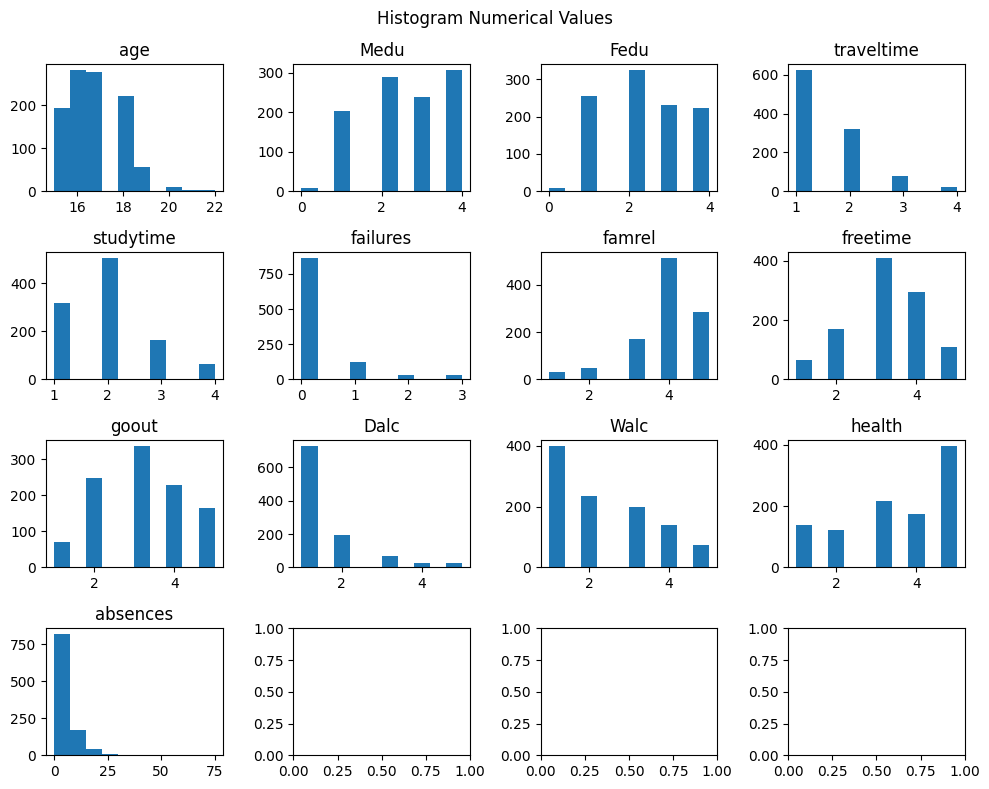

In [421]:
df_num = df[numerics]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

Balanceig categorics.

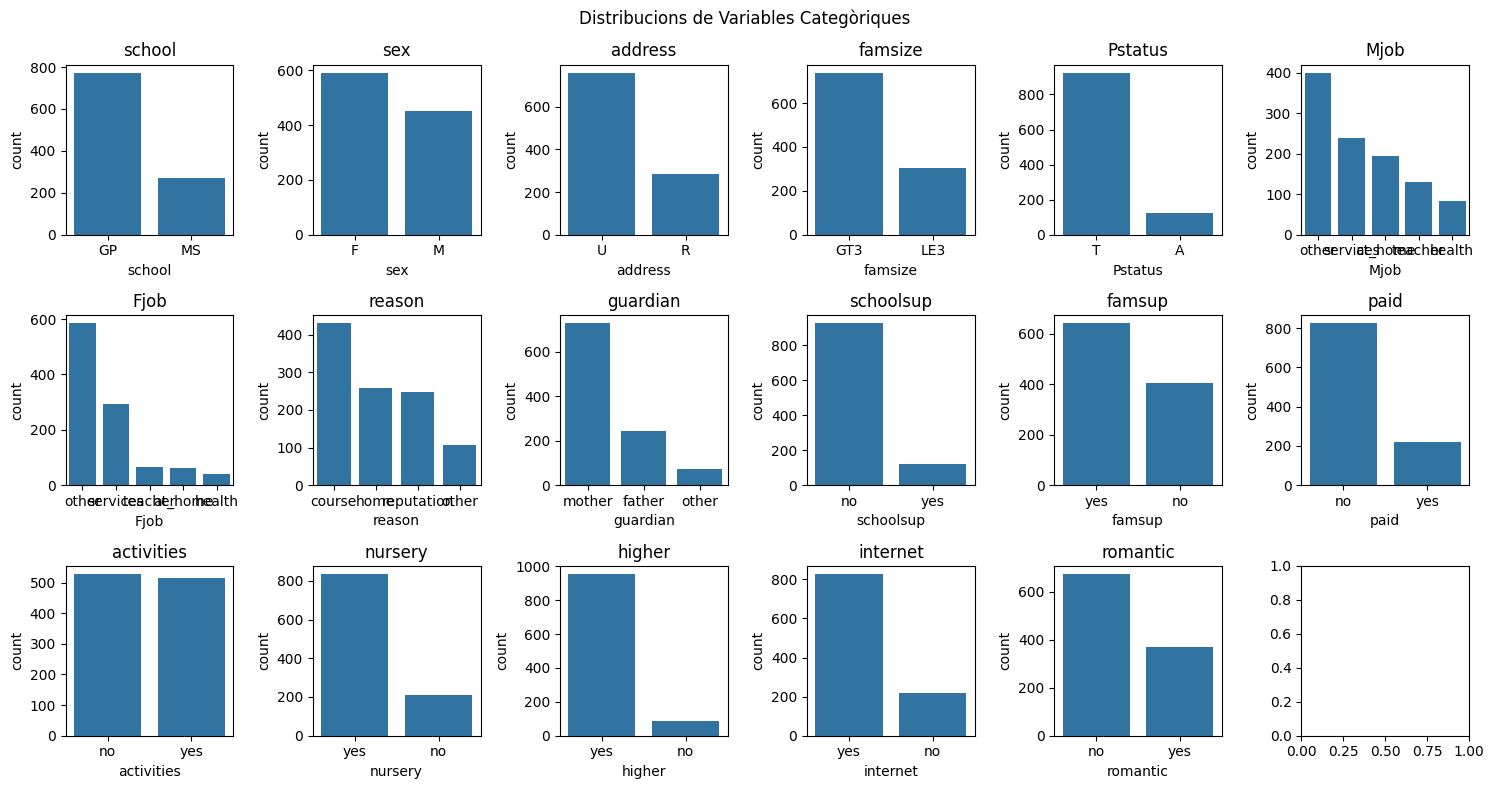

In [422]:
df_cat = df[categorics]
fig, axes = plt.subplots(3, 6, figsize=(15, 8))
fig.suptitle('Distribucions de Variables Categòriques')

for i, ax in enumerate(axes.ravel()):
    if i < df_cat.shape[1]:
        column_name = df_cat.columns[i]
        sns.barplot(x=df_cat[column_name].value_counts().index, y=df_cat[column_name].value_counts(), ax=ax)
        ax.set_ylabel('count')
        ax.set_title(column_name)

plt.tight_layout()
plt.show()

Balanceig targets.

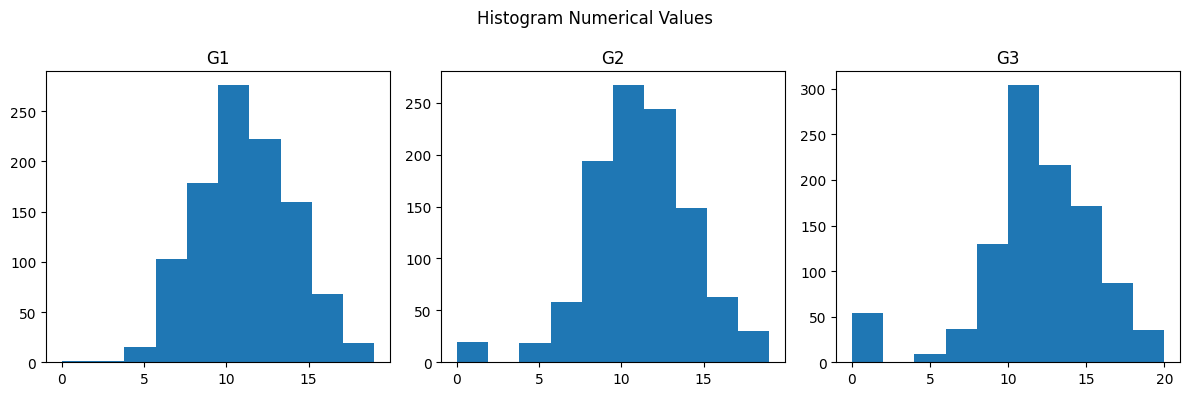

In [423]:
df_targ = df[targets]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_targ.columns, axes.ravel()):
    ax.hist(df_targ[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

Mirare la quantitat de 0 que hi ha en cada G ja que em pot fer sospitar que es degui a l'abandonament per part dels estudiants del curs al veures els G anteriors suspesos.

In [424]:
for target in targets:
    count_zeros = df[df[target] == 0].shape[0]
    print(f"Para el target '{target}' hay {count_zeros} valores '0'")

Para el target 'G1' hay 1 valores '0'
Para el target 'G2' hay 20 valores '0'
Para el target 'G3' hay 53 valores '0'


In [425]:
count_combinations = defaultdict(lambda: {'Aprobado': defaultdict(int), 'Suspendido': defaultdict(int)})

for index, row in df.iterrows():
    if any(row[target] == 0 for target in targets):
        for target in targets:
            if row[target] == 0:
                other_targets = [col for col in targets if col != target]
                for other_target in other_targets:
                    if row[other_target] > 9:
                        count_combinations[target]['Aprobado'][other_target] += 1
                    else:
                        count_combinations[target]['Suspendido'][other_target] += 1

# Mostrar el recuento de combinaciones para cada target que sea 0
print("Recuento de combinaciones para cada target que sea 0 dividido por otros targets:")
for target, counts in count_combinations.items():
    print(f"Para el target '{target}':")
    for key, value in counts.items():
        print(f"- {key}:")
        for other_target, count in value.items():
            print(f"   * {other_target}: {count}")


Recuento de combinaciones para cada target que sea 0 dividido por otros targets:
Para el target 'G3':
- Aprobado:
   * G1: 8
   * G2: 2
- Suspendido:
   * G1: 45
   * G2: 51
Para el target 'G2':
- Aprobado:
   * G1: 3
- Suspendido:
   * G3: 20
   * G1: 17
Para el target 'G1':
- Aprobado:
   * G2: 1
   * G3: 1
- Suspendido:


In [426]:
for target in targets:
    rows_with_zero = df[df[target] == 0]
    print(f"\nPara el target '{target}':")
    abs = 0
    for index, row in rows_with_zero.iterrows():
        abs += row['absences']
    print(abs)



Para el target 'G1':
4

Para el target 'G2':
0

Para el target 'G3':
0


### PROCESSING

He decidit quedarme amb tots els atributs del dataset ja que trobo que tots tenen rellevància per al model, encara que alguns més que altres, i tot i tenir bastants atributs categòrics després de fer una primera exploració no veig que tingui cap problema per a codificar, ja que la majoria són binaris.

He decidit quedarme amb tots els atributs del dataset menys amb el atribut nursery ja que trobo que tots tenen rellevància per al model, encara que alguns més que altres, i tot i tenir bastants atributs categòrics després de fer una primera exploració no veig que tingui cap problema per a codificar, ja que la majoria són binaris.

In [427]:
#df = df.drop(['nursery'], axis=1)

#### NORMALITZACIO

El primer que farem serà normalitzar logaritmicament les dades per a que tingui una distribució normal el més semblant possible. Seguidament, escalarem les dades per a que vagin de 0 a 1 com a minim i màxim, amb el Min-Max Scaling.

La normalització logarítmica s'utilitza per transformar dades amb distribucions sesgades o una ampla variabilitat, reduint el sesgament i l'amplitud dels valors. Ajudar a igualar la distribució, estabilitzar la variància, facilitar la interpretació i preparar les dades per a certs models, però la seva aplicabilitat depèn de la naturalesa de les dades i del context del problema.

In [428]:
def normalitzar(numerics, df):
    numerics_norm = [numeric + '_norm' for numeric in numerics]
    for nums, nums_norm in zip(numerics, numerics_norm):
        df[nums] = np.log1p(df[nums])
    
    scaler = MinMaxScaler()
    df[numerics] = scaler.fit_transform(df[numerics])
    df.isna().sum()
    
    df = df.drop(numerics, axis=1)

La funció principal del MinMaxScale és escalar les dades entre un rang específic, en aquest cas entre 0 i 1.  
El MinMaxScaler es una técnica de escalado que transforma los datos de tal manera que quedan en un rango específico, generalmente entre 0 y 1. Ens facilita la seva comparació ja que tots les variables categoriques tenen el mateix rang de dades.

In [429]:
def show_numerics(numerics_norm):
    df_num = df[numerics_norm]
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
    fig.suptitle('Histogram Numerical Values')

    for i, ax in zip(df_num.columns, axes.ravel()):
        ax.hist(df_num[i], bins=10)
        ax.set_title(i)

    plt.tight_layout()

#### ENCODING

Per a aquest apartat he decidit fer dos tipus d'encoding. Fare sevir el LabelEncoder per als atributs binaris i el OneHotEncoding per als altre.  
Això ho faig perque el LabelEncoder pot, avegades, afegir un ordre intrinsic que no existeix realment en les dades del dataset i es per això que pels atributs que no son binaris he decidit fer servir el OneHotEncoder. One Hot Encoder ens afegeix una columna nova per cadascuna de les classes de la columna codificada i posa un 1 a la fila que correspon amb la categoria. Això fa que la dimensionalitat del dataset augmenti molt per això amb les binaries faré un LabelEncoder.

In [430]:
binary = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
non_binary = ['Mjob', 'Fjob', 'reason', 'guardian']

In [431]:
def encoder(binary, non_binary, df):
    label_encoder = LabelEncoder()
    for attr in binary:
        encoded_values = label_encoder.fit_transform(df[attr])
        df[attr] = encoded_values
        
    for attr in non_binary:
        encoder = OneHotEncoder(sparse=False)
        attribute_encoded = encoder.fit_transform(df[[attr]])

        new_column_names = encoder.get_feature_names_out(input_features=[attr])
        encoded_df = pd.DataFrame(attribute_encoded, columns=new_column_names, index=df.index)

        df = df.drop([attr], axis=1)
        df = pd.concat([df, encoded_df], axis=1)
    return df

In [432]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [433]:
def show_correlations(numerics_norm, binary, df):
    numericsG1 = numerics_norm.copy()
    numericsG1.extend(binary.copy())
    numericsG2 = numerics_norm.copy()
    numericsG2.extend(binary.copy())
    numericsG3 = numerics_norm.copy()
    numericsG3.extend(binary.copy())

    numericsG1.insert(0, 'G1')
    numericsG2.insert(0, 'G2')
    numericsG2.insert(1, 'G1')
    numericsG3.insert(0, 'G3')
    numericsG3.insert(1, 'G1')
    numericsG3.insert(2, 'G2')

    correlation_matrix_G1 = df[numericsG1].corr()
    first_row_correlation_G1 = correlation_matrix_G1.iloc[[0]]

    correlation_matrix_G2 = df[numericsG2].corr()
    first_row_correlation_G2 = correlation_matrix_G2.iloc[[0]]

    correlation_matrix_G3 = df[numericsG3].corr()
    first_row_correlation_G3 = correlation_matrix_G3.iloc[[0]]

    plt.figure(figsize=(15, 6))

    plt.subplot(3, 1, 1)
    sns.heatmap(first_row_correlation_G1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Primera fila de la matriz de correlación - G1')

    plt.subplot(3, 1, 2)
    sns.heatmap(first_row_correlation_G2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Primera fila de la matriz de correlación - G2')

    plt.subplot(3, 1, 3)
    sns.heatmap(first_row_correlation_G3, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Primera fila de la matriz de correlación - G3')

    plt.tight_layout()
    plt.show()
    
    return [first_row_correlation_G1, first_row_correlation_G2, first_row_correlation_G3]

### 3. MODEL SELECTION AMB CV

En aquest apartat entrenarem 6 models diferents de classificació. Aquests són: LogisticRegression, SVM, KNN, RandomForest, XGBoost i AdaBoost. La selecció d'aquests classificadors ha estat influenciada pel nostre coneixement actual sobre aquests models. Són models que hem estudiat i coneixem superficialment el seu funcionament. Els avaluarem segons la mètrica de f1-score per decidir quin és el millor.

Per entrenar-los farem servir el cross validation i, posteriorment, farem una cerca d'hiperparàmetres per a que els models puguin ser el mes precisos posible.

És important fer servir la validació creuada a l'entrenament dels models per evitar possibles Overfittings o Underfittings. Sobretot per que tractem amb un dataset desbalancejat, al qual una partició errònia al fer el entrenament ens portaria a resultats no desitjats. 

Una decisió important a la validació és la selecció d'un bon hyperparametre n_splits que és equivalent a la k. Un valor petit com 3 o 5 pot tenir un cost computacional bastant baix, però a la vegada pot provocar major variança i bias. En canvi, un valor alt com 10, encara que té més cost computacional, a canvi tindrà menys variança i bias, aixó doncs obtenim mesures més estables i representatives. 

Resumidament, aquest procediment ens proporciona una mesura del rendiment més que fiable de cada model ja que avalua el comportament del model amb diferents particions.  

Concretament farem servir el StratifiedK-Fold CV el qual divideix el dataset en k particions, assegurant-se que en cada partició es guardi la proporció d'exemples de cada clase del dataset original, entrenant el model amb les k particions i fent la mitja per a quedar-se amb el resultat final. El StratifiedK-Fold CV és més útil que el K-Fold CV quan les dades estan desbalancejades, que és el nostre cas, ja que assegura equitat a la distribució de les classes als subconjunts de dades.

In [434]:
def get_correlations(first_row_correlation):
    positive_correlation = first_row_correlation[first_row_correlation > 0].dropna(axis=1)
    attributes_with_positive_corr = positive_correlation.columns.tolist()
    attributes_with_positive_corr = attributes_with_positive_corr[1:]
    
    return attributes_with_positive_corr

#### OUTLIERS

In [435]:
def show_outliers(df, target):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[target], flierprops=dict(markerfacecolor='r', marker='D'))
    plt.show()

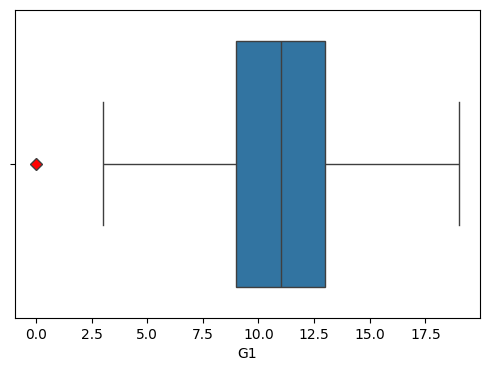

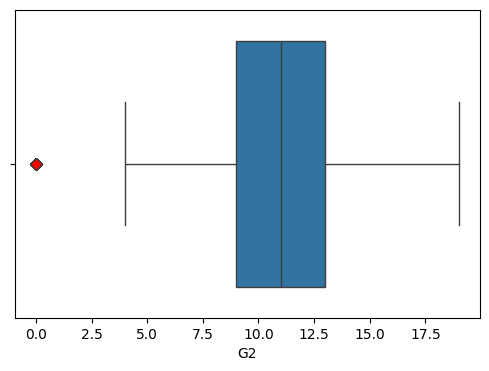

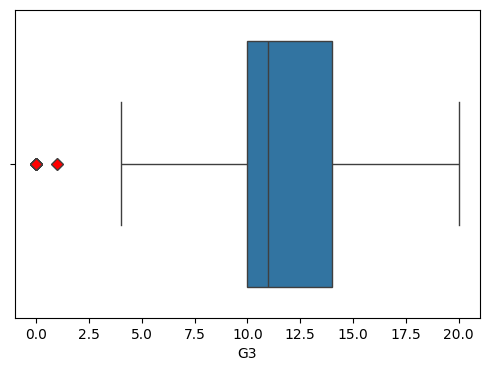

In [436]:
for target in targets:
    show_outliers(df, target)

In [437]:
def get_valors_outliers(df, target):
    outliers = df[target]

    Q1 = np.percentile(outliers, 25)
    Q3 = np.percentile(outliers, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_indices = df[(df[target] < lower_bound) | (df[target] > upper_bound)].index

    return outliers_indices

def outliers_iguals(outliers1, outliers2):
    return all(outlier in outliers2 for outlier in outliers1)

In [438]:
outliers = {'G1' : 0, 'G2' : 0, 'G3' : 0}

for k in outliers.keys():
    outliers[k] = get_valors_outliers(df, k)


TREURE OUTLIERS

In [439]:
def treure_outliers(outliers, df):
    df = df.drop(outliers, axis=0)

In [440]:
for out1 in outliers.values():
    for out2 in outliers.values():
        if outliers_iguals(out1, out2):
            break
        else:
            treure_outliers(out1, df)
            break        

#### REGRESIO

In [441]:
# normalitzar(numerics, df)
# df = encoder(binary, non_binary, df)
X = df.drop(['G3'], axis=1)
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

normalitzar(numerics, X_train)
X_train = encoder(binary, non_binary, X_train)

normalitzar(numerics, X_test)
X_test = encoder(binary, non_binary, X_test)

RF = GradientBoostingRegressor()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 2.5753818505370147
R2 Score: 0.8334252549614607


In [442]:
X = df[['G2']]
#X = df[attributes_with_positive_corr]
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=7)  # Selecciona el grado polinómico
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 2.959526828371763
R2 Score: 0.8085788999530507


In [443]:
models_scores = {'Sense hyperparametres': {'SVR': 0, 'LR': 0, 'RF': 0, 'GBR': 0, 'PF' : 0, 'Lasso' : 0, 'Ridge' : 0}, 'Amb hyperparametres': {'SVR': 0, 'LR': 0, 'RF': 0, 'GBR': 0, 'PF' : 0, 'Lasso' : 0, 'Ridge' : 0}}

classifiers = {'SVR': SVR(), 'LR': LinearRegression(), 'RF': RandomForestRegressor(), 'GBR' : GradientBoostingRegressor(), ''' 'PF' : PolynomialFeatures(), ''' 'Lasso' : Lasso(), 'Ridge' : Ridge()}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X = df.drop(['G3', 'G2'], axis=1)
y = df['G3']

def avaluacio_models_k_fold(model, stratified_kfold, models_scores, model_name):
    y_preds = []
    y_tests = []
    r2_acc = []
    mse_acc = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        normalitzar(numerics, X_train)
        X_train = encoder(binary, non_binary, X_train)

        normalitzar(numerics, X_test)
        X_test = encoder(binary, non_binary, X_test)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2_acc.append(r2)
        mse_acc.append(mse)
        y_preds.extend(y_pred)
        y_tests.extend(y_test)
    scores = {'r2' : np.array(r2_acc).mean(), 'mse' : np.array(mse_acc).mean()}
    models_scores['Sense hyperparametres'][model_name] = scores

for model_name, model in classifiers.items():
    avaluacio_models_k_fold(model, kfold, models_scores, model_name)

In [444]:
models_scores["Sense hyperparametres"]

{'SVR': {'r2': 0.6264594115123933, 'mse': 5.567023014557796},
 'LR': {'r2': 0.6494927755951452, 'mse': 5.19435654831546},
 'RF': {'r2': 0.6957085811269803, 'mse': 4.494711079192354},
 'GBR': {'r2': 0.7149371040729724, 'mse': 4.211397389916591},
 'PF': 0,
 'Lasso': 0,
 'Ridge': {'r2': 0.6503924914382315, 'mse': 5.181512011372901},
 " 'PF' : PolynomialFeatures(), Lasso": {'r2': 0.64430427041084,
  'mse': 5.293117363685672}}

#### Cerca d'hyperparametres

Escollir els paràmetres idonis per entrenar el model pot ser una tasca tediosa. Existeixen per això tècniques que et troben la millor combinació d'hyperparametres possible. Aquests són alguns com GridSearchCV, RandomizedSearchCV o HalvingRandomSearchCV.

En termes de cost computacional, podem dir que la primera és la més costosa per la seva exhaustivitat al provar cada combinació possible. Les dues altres opcions, molt menys costoses, poden resultar més eficients en segons que aspectes, però hem de tenir en compte que necessitem la millor combinació possible de hyperparametres. Així doncs, escollim la exhaustivitat del GridSearch respecte la eficiència del RandomizedSearch.

Per analisis encara més profunds, podriem parlar de tècniques de cerca encara més eficients. Aquestes les podem extreure de llibrerias com scikit-optimize. Un possible exemple seria l'optimització Bayesiana. Aquesta modela la funció objectiu i fa la cerca en funció del rendiment, sempre tractant de maximitzar-lo. Altre mètode d'optimització és Tunning, on bàsicament es fa una optimització de hyperparametres per afinar encara més el rendiment en un conjunt de dades específic. No confondre amb el fine-tunning, que no ajusta hyperparametres si no un model entrenat previament.

In [452]:
# normalitzar(numerics, df)
# df = encoder(binary, non_binary, df)
X = df.drop(['G3', 'G2'], axis=1)
y = df['G3']


def grid_search(model, param_grid, X, y, cv):
    start_time = time.time()
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring='r2', cv=cv, verbose=True, n_jobs=-1)
    end_time = time.time()
    duration = end_time - start_time
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(best_params, best_score)
    scores = {'r2_score': best_score, 'mean_squared_error': mse}
    return scores, best_params, y_pred, duration

# Definición de modelos y sus respectivos hiperparámetros
models = {
    'SVR': SVR(),
    'LR': LinearRegression(),
    'RF': RandomForestRegressor(),
    'GBR': GradientBoostingRegressor(),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

# Define los hiperparámetros específicos para cada modelo
param_grids = {
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LR': {
        'fit_intercept' : [True, False],
    },
    'RF': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'GBR': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10]
    },
    'Lasso': {
        'alpha': [0.1, 0.5, 1.0],
        'fit_intercept': [True, False]
    },
    'Ridge': {
        'alpha': [0.1, 0.5, 1.0],
        'fit_intercept': [True, False]
    }
}

# Llama a la función grid_search para cada modelo
results = []
y_preds = []
for model_name, model in models.items():
    params = param_grids[model_name]
    best_score, best_params, preds, duration = grid_search(model, params, X, y, kfold)
    results.append({
        'Model': model_name,
        'Millors Parametres': best_params,
        'Millor Scores': best_score,
        'Time' : duration
    })
    models_scores['Amb hyperparametres'][model_name] = best_score
    y_preds.append(preds)
    print(models_scores['Amb hyperparametres'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'} 0.6487435420767133
{'SVR': {'r2_score': 0.6487435420767133, 'mean_squared_error': 4.049515253708435}, 'LR': {'r2_score': 0.6540386833898635, 'mean_squared_error': 4.634480453353693}, 'RF': {'r2_score': 0.706192517887369, 'mean_squared_error': 1.8291466066489268}, 'GBR': {'r2_score': 0.7224799938173729, 'mean_squared_error': 3.0544928664027253}, 'PF': 0, 'Lasso': 0, 'Ridge': 0}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'fit_intercept': False} 0.6540386833898635
{'SVR': {'r2_score': 0.6487435420767133, 'mean_squared_error': 4.049515253708435}, 'LR': {'r2_score': 0.6540386833898635, 'mean_squared_error': 4.634480453353693}, 'RF': {'r2_score': 0.706192517887369, 'mean_squared_error': 1.8291466066489268}, 'GBR': {'r2_score': 0.7224799938173729, 'mean_squared_error': 3.0544928664027253}, 'PF': 0, 'Lasso': 0, 'Ridge': 0}
Fitting 5 folds for each of 162 candidates, totall

In [456]:
results_2 = []
for result in results:
    results_2.append({
        'Model': result['Model'],
        #'Millors Parametres': result['Millors Parametres'],
        'Millor Scores R2': result['Millor Scores']['r2_score'],
        'Millor Scores MSE': result['Millor Scores']['mean_squared_error'],
        'Time': result['Time']
    })

df = pd.DataFrame(results_2)
df

,Model,Millor Scores R2,Millor Scores MSE,Time
0,SVR,0.648744,4.049515,0.0
1,LR,0.654039,4.634480,0.0
2,RF,0.706966,1.867421,0.0
3,GBR,0.722336,3.077505,0.0
4,Lasso,0.653516,5.139330,0.0
5,Ridge,0.654931,4.634622,0.0
